# Clone repo to access resources

In [0]:
!git clone https://github.com/idealo/cnn-exposed.git  

Cloning into 'cnn-exposed'...
remote: Enumerating objects: 55, done.
remote: Total 55 (delta 0), reused 0 (delta 0), pack-reused 55
Unpacking objects: 100% (55/55), done.


In [0]:
cd cnn-exposed/

/content/cnn-exposed/cnn-exposed/cnn-exposed/cnn-exposed/cnn-exposed/cnn-exposed/cnn-exposed/cnn-exposed/cnn-exposed


# Setup

In [0]:
# import packages
import os
import pathlib
import requests

import numpy as np
import matplotlib.image as mpimg

from PIL import Image
from io import BytesIO
from skimage import feature, transform
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
%matplotlib inline

# import keras dependencies
from keras.models import Model
from keras.applications import MobileNet as CNN
from keras.applications.mobilenet import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.utils import to_categorical
import keras.backend as K

### Declare some helper functions

In [0]:
def plot_single_image(image_path, fig_size=(10, 10), dpi=100):
    figure(figsize=fig_size, dpi=dpi)
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.grid(False)
    plt.axis('off')
    plt.show()
    

# Plotting function for saliency maps
def plot_custom(data, xi=None, cmap='RdBu_r', axis=plt, percentile=100, dilation=3.0, alpha=0.8):
    dx, dy = 0.05, 0.05
    xx = np.arange(0.0, data.shape[1], dx)
    yy = np.arange(0.0, data.shape[0], dy)
    xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
    extent = xmin, xmax, ymin, ymax
    cmap_xi = plt.get_cmap('Greys_r')
    cmap_xi.set_bad(alpha=0)
    overlay = None
    if xi is not None:
        # Compute edges (to overlay to heatmaps later)
        xi_greyscale = xi if len(xi.shape) == 2 else np.mean(xi, axis=-1)
        in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
        edges = feature.canny(in_image_upscaled).astype(float)
        edges[edges < 0.5] = np.nan
        edges[:5, :] = np.nan
        edges[-5:, :] = np.nan
        edges[:, :5] = np.nan
        edges[:, -5:] = np.nan
        overlay = edges

    abs_max = np.percentile(np.abs(data), percentile)
    abs_min = -abs_max

    if len(data.shape) == 3:
        data = np.mean(data, 2)
    axis.imshow(data, extent=extent, interpolation='bicubic', cmap=cmap, vmin=abs_min, vmax=abs_max)
    if overlay is not None:
        axis.imshow(overlay, extent=extent, interpolation='bicubic', cmap=cmap_xi, alpha=alpha)
    axis.axis('off')
    return axis


def plot_comparison(target_image_path, map_array, title=''):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(26, 20))

    img_orig = Image.open(target_image_path).resize((224, 224))
    xi = (map_array[0,:] - np.min(map_array[0,:]))
    xi /= np.max(xi)

    ax = axes.flatten()[0]
    ax.imshow(img_orig)
    ax.set_title('Original', fontdict={'fontsize': 20})
    ax.axis('off')

    plot_custom(attributions[0], xi = xi, axis=axes[1], dilation=.5, percentile=99, alpha=.2).set_title(title, fontdict={'fontsize': 20})
    plt.show()

    
def plot_gradcam(original_image_path, loaded_image, grads):
    fig, axs = plt.subplots(1, 2, figsize=(16, 10), constrained_layout=True)

    img_orig = Image.open(original_image_path).resize((224, 224))
    axs[0].imshow(img_orig, aspect='auto')
    axs[0].grid(False)

    axs[1].imshow(overlay(grads, loaded_image), aspect='auto')
    axs[1].grid(False)

In [0]:
path_resources = pathlib.Path('resources/attribution/')

# Image classification
We wish to classify the below image with true label for the dog breed: Australian Terrier

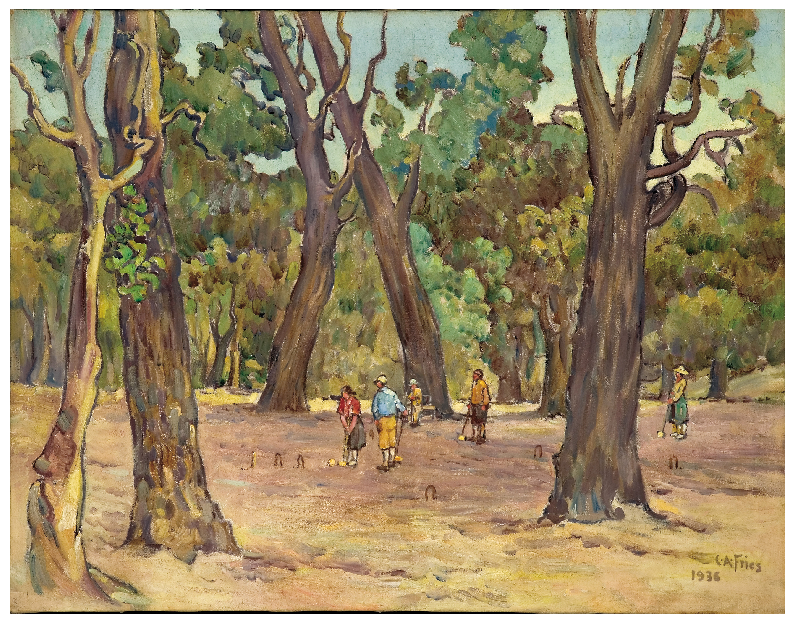

In [0]:
target_image = '/content/Game of Croquet.png'
plot_single_image(target_image)

## Python package: DeepExplain
(https://github.com/marcoancona/DeepExplain#egg=deepexplain)

In [0]:
# Get the model (Mobilenet Pretrained on ImageNet dataset)
model = CNN(include_top=True)

In [0]:
# Get the prediction
loaded_image = np.array(image.load_img(target_image, target_size=(224, 224)))
processed_image = preprocess_input(loaded_image)
preds = model.predict(processed_image[np.newaxis, :])
preds_name = decode_predictions(preds)
preds_name

[[('n02115913', 'dhole', 0.21715795),
  ('n09428293', 'seashore', 0.180022),
  ('n04371774', 'swing', 0.06756757),
  ('n02504013', 'Indian_elephant', 0.05992364),
  ('n02129165', 'lion', 0.053951778)]]

## Install Deepexplain package for plotting saliency maps

In [0]:
!pip install git+https://github.com/marcoancona/DeepExplain.git#egg=deepexplain

In [0]:
# import deepexplain to draw saliency maps
from deepexplain.tensorflow import DeepExplain

In [0]:
# Get saliency map
# Refer the API documentation for using deepexplain as below
with DeepExplain(session=K.get_session()) as de:
    model = CNN(include_top=True)
    input_tensor = model.layers[0].input
    fModel = Model(inputs=input_tensor, outputs = model.layers[-1].output)
    target_tensor = fModel(input_tensor)
    top_idx = preds.argsort()[::-1]
    ys = to_categorical(top_idx, num_classes=1000)
    xs = np.tile(processed_image, (1, 1, 1, 1))
    attributions = de.explain('saliency', fModel.outputs[0] * ys, fModel.inputs[0], xs)

/usr/local/lib/python3.6/dist-packages/deepexplain/tensorflow/methods.py:640: UserWarning: Detected unsupported activation (Relu6). This might lead to unexpected or wrong results.
  'This might lead to unexpected or wrong results.' % op.type)
/usr/local/lib/python3.6/dist-packages/deepexplain/tensorflow/methods.py:611: UserWarning: DeepExplain detected you are trying to use an attribution method that requires gradient override but the original gradient was used instead. You might have forgot to (re)create your graph within the DeepExlain context. Results are not reliable!
  warnings.warn('DeepExplain detected you are trying to use an attribution method that requires '


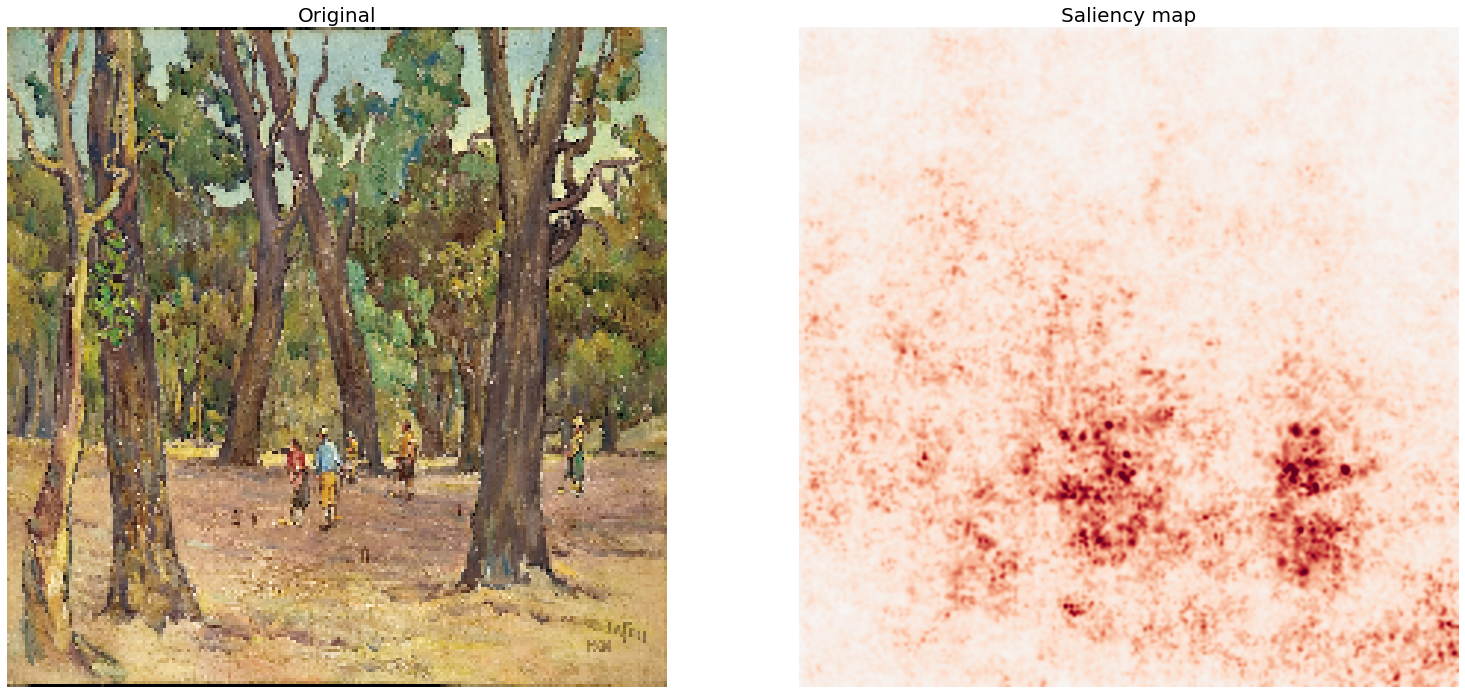

In [0]:
plot_comparison(target_image, attributions, title='Saliency map')

## Saliency Map Pros:

*   Fine-grained understanding of relative contribution of pixels 

## Saliency Map Cons:
* Propagation of gradient is hard (due to non-linearlities such as relu which makes the gradient discontinuous)

# Class Activation Map (CAM) 
## Learning Deep Features for Discriminative Localization
by Zhou et. al

(http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf)

In [0]:
cam_diagram = os.path.join(path_resources, '/content/Game of Croquet.png')
plot_single_image(cam_diagram, fig_size=(15, 15))

Output hidden; open in https://colab.research.google.com to view.

## CAM Pros:

*   No calculation of gradients needed
*   Intuitive to understand

## CAM Cons:
* Bound to a fixed architecture (Conv -> GAP -> Dense)

# Gradient Class Activation Map (Grad-CAM)

## Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization

by Selvaraju et.al (https://arxiv.org/pdf/1610.02391.pdf)

## Install keras-vis package for obtaining grad-cam

(https://github.com/raghakot/keras-vis)

In [0]:
!pip install keras-vis


In [0]:
# import specific functions from keras-vis package
from vis.utils import utils
from vis.visualization import visualize_cam, overlay

In [0]:
# Get layer for which Grad-CAM needs to be obtained ('conv_preds' is the name of
# the convolution layer closest to the output layer. Refer the output of 
# model.summary()). Any convolution layer can be visualized (not only the one 
# closest to the output)
layer_idx = utils.find_layer_idx(model, 'conv_preds')

In [0]:
grads = visualize_cam(model, layer_idx, filter_indices=np.argmax(preds), seed_input=processed_image, backprop_modifier=None)

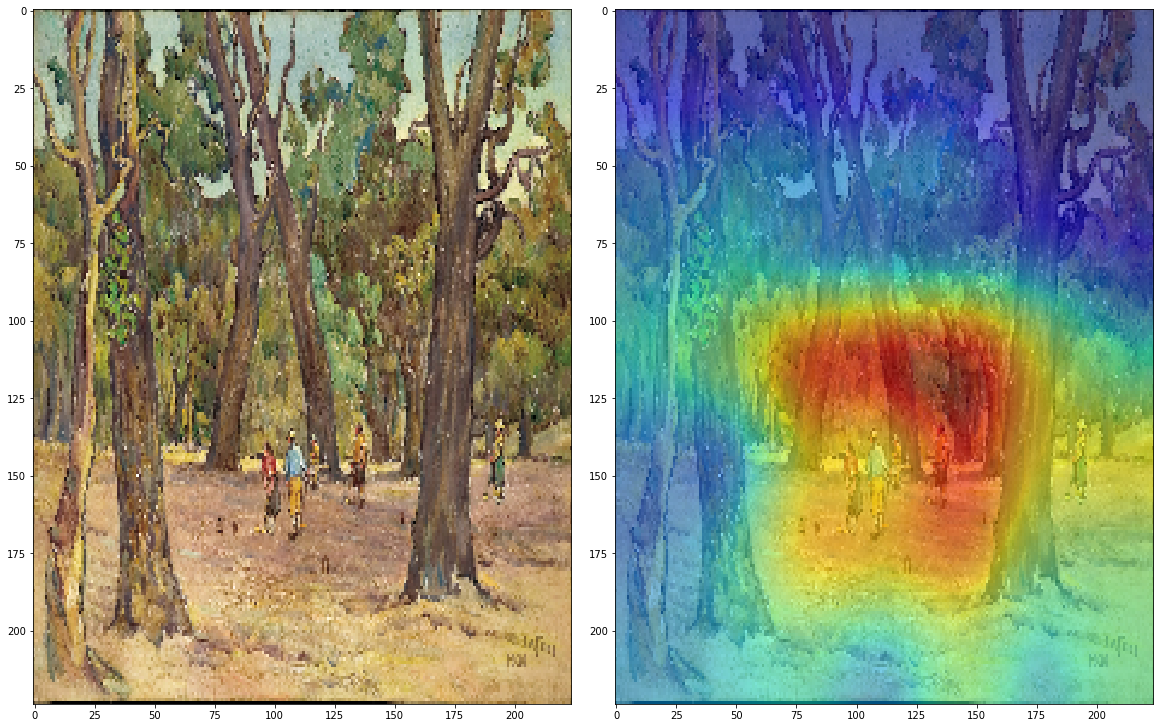

In [0]:
plot_gradcam(target_image, loaded_image, grads)